# Mask R-CNN - Train on Concrete Dataset

In [47]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [104]:
class ConcreteConfig(Config):
    """Configuration for training on the concrete dataset.
    Derives from the base Config class and overrides values specific
    to our own dataset.
    """
    # Give the configuration a recognizable name
    NAME = "concrete"

    # Train on 1 GPU and 4 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 4 (GPUs * IMAGES_PER_GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 classes

    # Set the limits of the small side and the large side,
    # which determines the image shape. 
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Set number of steps per epoch
    STEPS_PER_EPOCH = 100

    # Use small validation steps for testing purpose
    VALIDATION_STEPS = 5
    
config = ConcreteConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preferences

In [105]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Extend the Dataset class and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [109]:
import skimage.io

class ConcreteDataset(utils.Dataset):
    """
    The dataset consists of concrete CT images.
    """

    def load_concrete(self, dataset_dir, subset):
        """Load a subset of the concrete dataset.
        dataset_dir: Root directory of the dataset
        subset: train, val, or test
        """
        # Add classes
        self.add_class("concrete", 1, "A")
        self.add_class("concrete", 2, "B")
        self.add_class("concrete", 3, "C")
        self.add_class("concrete", 4, "M")
        
        assert subset in ["train", "val", "test"]
        dataset_dir = os.path.join(dataset_dir, subset, 'X')
        image_ids = next(os.walk(dataset_dir))[2]

        for img in image_ids:
            if img.endswith(".tif"):
                self.add_image(
                    "concrete",
                    image_id=img[:-4],
                    path=os.path.join(dataset_dir, img))

                
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "concrete":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)
            

    def load_mask(self, image_id):
        """Generate instance masks for concrete of the given image ID.
        """
        info = self.image_info[image_id]
        path = info['path']
        mask_path = os.path.join(os.path.dirname(os.path.dirname(info['path'])), 'y')
        mask_dirs = ['A_phase', 'B_phase', 'C_phase', 'M_phase']
        image_name = os.path.split(path)[-1]
        
        # Read mask files from .tif image
        mask = []
        for i in range(len(mask_dirs)):
            image = os.path.join(mask_path, mask_dirs[i], image_name)
            m = skimage.io.imread(image).astype(np.bool)
            mask.append(m)
            
        mask = np.stack(mask, axis=-1)
        class_ids = np.array([1, 2, 3, 4], dtype=np.int32)
        return mask, class_ids

In [118]:
##############################
# Structure of the dataset:
# -dataset_dir
#     -train
#       -X
#       -y
#         -A_phase
#         -B_phase
#         -C_phase
#         -M_phase
#    -val
#       -X
#       -y
#         -A_phase
#         -B_phase
#         -C_phase
#         -M_phase
#   -test
#       -X
###############################

# Set path to the dataset
dataset_dir = os.path.join(ROOT_DIR, "dataset")

# Training dataset
dataset_train = ConcreteDataset()
dataset_train.load_concrete(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = ConcreteDataset()
dataset_val.load_concrete(dataset_dir, "val")
dataset_val.prepare()

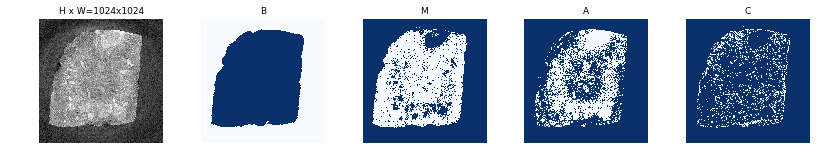

In [119]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 1)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [120]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [114]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. Simply pass `layers="all` to train all layers.

In [121]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/yingying/Library/Mobile Documents/com~apple~CloudDocs/282A CS/final proj/Mask_RCNN_concrete/logs/concrete20190430T2009/mask_rcnn_concrete_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class

In [123]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=160, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/yingying/Library/Mobile Documents/com~apple~CloudDocs/282A CS/final proj/Mask_RCNN_concrete/logs/concrete20190430T2009/mask_rcnn_concrete_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Con

In [124]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_xxx.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [125]:
class InferenceConfig(ConcreteConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /Users/yingying/Library/Mobile Documents/com~apple~CloudDocs/282A CS/final proj/Mask_RCNN_concrete/logs/concrete20190430T2009/mask_rcnn_concrete_0001.h5
Re-starting from epoch 1


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (4,)                  min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (4, 4)                min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool


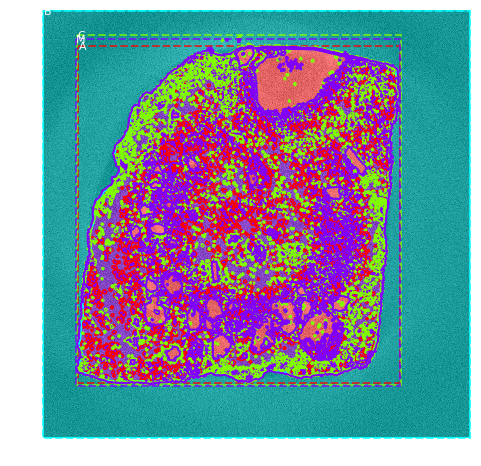

In [126]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


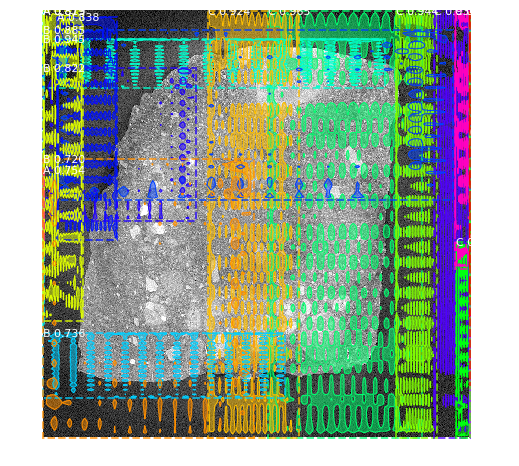

In [127]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [128]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 2 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 2)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
